In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import os
from src.dataloader import SpotifyDataLoader

C:\Users\trist\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataloader = SpotifyDataLoader(os.path.join('..', 'regression_task', 'train_data.csv'), os.path.join('..', 'regression_task', 'test_data.csv'))
X, y = dataloader.load_data()

### Data Summary

In [3]:
print("train.head() :\n", X.head())
print('\n\ntrain.info(): \n', X.info())
print('\n\ntrain.describe(): \n', X.describe())

train.head() :
    duration_ms  explicit  danceability  energy  key  loudness  mode  \
0       187159      True         0.809   0.269    0   -17.422     1   
1       145514     False         0.724   0.280    9   -12.788     1   
2       131226     False         0.765   0.387    7    -6.799     1   
3       194706     False         0.598   0.447    8    -7.932     1   
4       200461     False         0.430   0.543    8    -6.296     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.1020         0.659          0.006490    0.1200    0.480  127.011   
1       0.0303         0.755          0.000000    0.3260    0.527  106.966   
2       0.1470         0.908          0.000000    0.1850    0.839  159.966   
3       0.0404         0.224          0.000000    0.0704    0.365  123.855   
4       0.0367         0.463          0.000523    0.0928    0.354  143.912   

   time_signature track_genre  
0               4     swedish  
1               4    aco

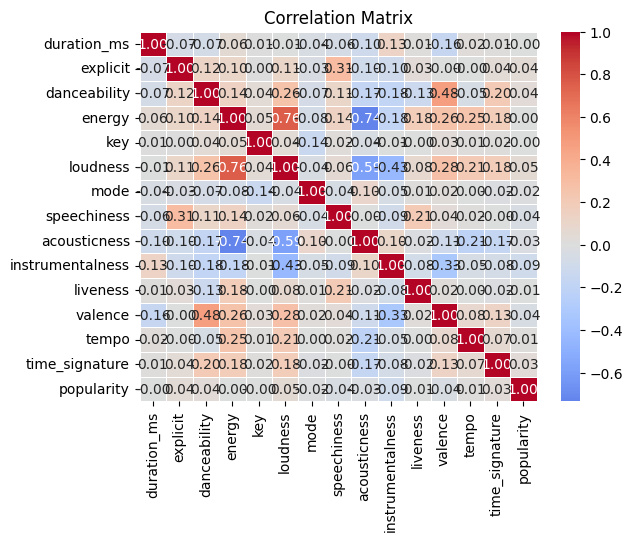

In [7]:
sns.heatmap(
    (pd.concat([X.drop(columns=["track_genre"]),y], axis=1)).corr(),
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation Matrix")
plt.show()

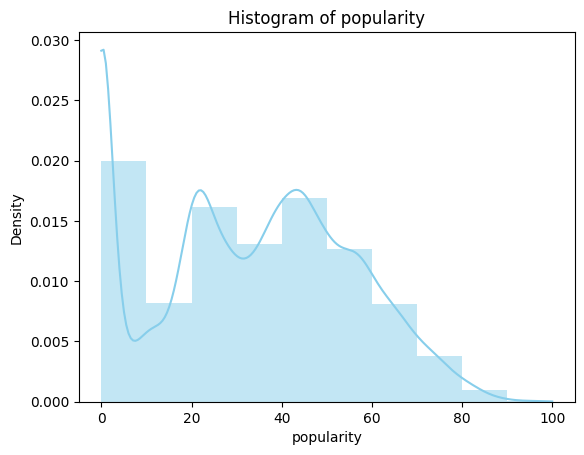

In [41]:
sns.histplot(y, kde=True, bins=10, color='skyblue', stat='density', linewidth=0)
plt.xlabel('popularity')
plt.ylabel('Density')
plt.title('Histogram of popularity')
plt.show()

1 popularity : 32.90536352800954


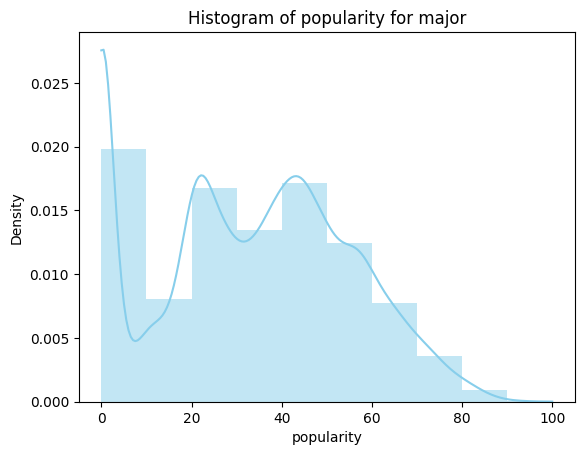

0 popularity : 33.67715162279993


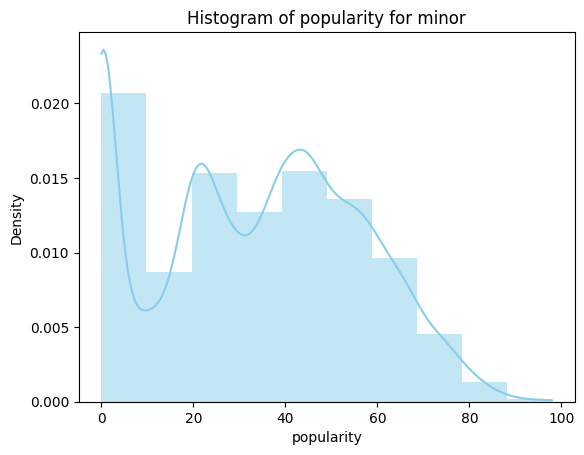

In [46]:
for mode in X["mode"].unique():
    mode_popularity = y[X["mode"]==mode] #X[X["mode"]==mode]["danceability"]
    print(f"{mode} popularity : {mode_popularity.mean()}")
    sns.histplot(mode_popularity, kde=True, bins=10, color='skyblue', stat='density', linewidth=0)
    plt.xlabel('popularity')
    plt.ylabel('Density')
    plt.title(f'Histogram of popularity for {"major" if mode==1 else "minor"}')
    plt.show()

swedish popularity : 36.8167115902965


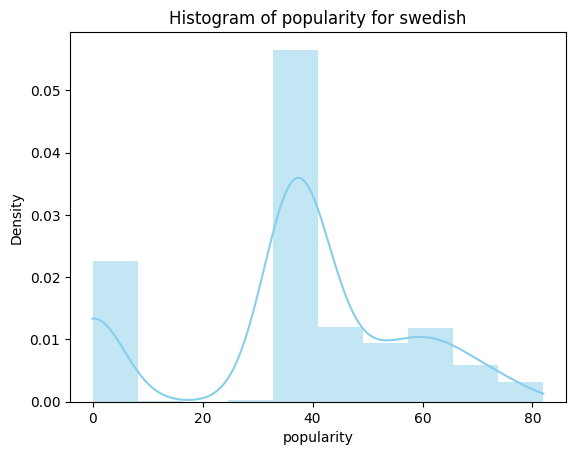

acoustic popularity : 42.02356020942408


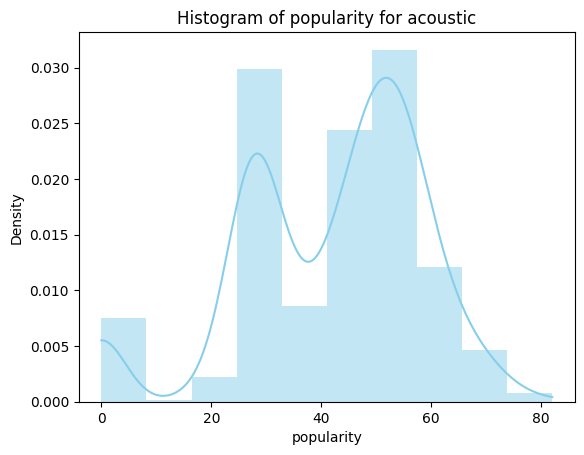

children popularity : 35.08559782608695


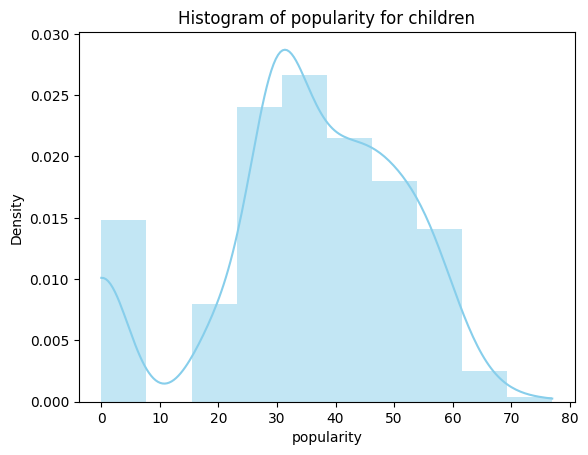

j-pop popularity : 40.745718050065875


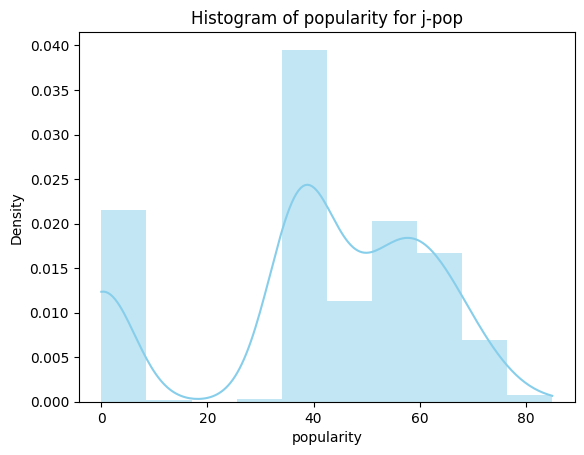

jazz popularity : 14.104031209362809


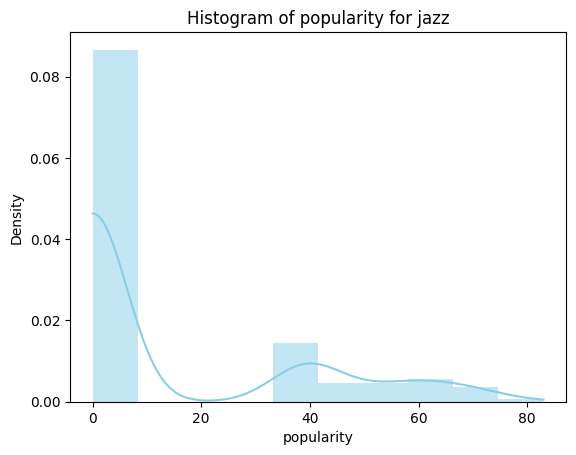

In [45]:
for genre in X["track_genre"].unique()[:5]:
    genre_popularity = y[X["track_genre"]==genre] #X[X["track_genre"]==genre]["danceability"]
    print(f"{genre} popularity : {genre_popularity.mean()}")
    sns.histplot(genre_popularity, kde=True, bins=10, color='skyblue', stat='density', linewidth=0)
    plt.xlabel('popularity')
    plt.ylabel('Density')
    plt.title(f'Histogram of popularity for {genre}')
    plt.show()

In [4]:
def plot_reduced_data(red_dict, y, title, component_names=None):
    for category in red_dict.keys():
        X_reduced = red_dict[category]['X_red']
        y_filtered = y[red_dict[category]['filter']]

        if X_reduced.shape[1] == 2:
            fig = px.scatter(
                x=X_reduced[:, 0],
                y=X_reduced[:, 1],
                color=y_filtered,
                title=title + ' ' + category,
                labels={'x': component_names[0] if component_names else 'Component 1',
                        'y': component_names[1] if component_names else 'Component 2'}
            )
        elif X_reduced.shape[1] == 3:
            fig = px.scatter_3d(
                x=X_reduced[:, 0],
                y=X_reduced[:, 1],
                z=X_reduced[:, 2],
                color=y_filtered,
                title=title + ' ' + category,
                labels={'x': component_names[0] if component_names else 'Component 1',
                        'y': component_names[1] if component_names else 'Component 2',
                        'z': component_names[2] if component_names else 'Component 3'}
            )
        else:
            raise ValueError("X_reduced must have 2 or 3 components.")
        fig.show()

def plot_explained_variance(pca):
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.xlabel('Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')
    plt.show()

def plot_feature_loadings(pca, feature_names, components=[0, 1, 2]):
    """
    Plot feature loadings in 2D (circle) or 3D (sphere) using Plotly.

    Args:
        pca: Fitted PCA or SparsePCA object.
        feature_names: List of feature names.
        components: List of component indices to plot (e.g., [0, 1] for 2D, [0, 1, 2] for 3D).
    """
    # Extract loadings for the selected components
    loadings = pca.components_[components, :].T  # Shape: (n_features, 2 or 3)

    # Normalize loadings to lie on a unit circle/sphere
    norms = np.linalg.norm(loadings, axis=1)
    normalized_loadings = loadings / norms[:, np.newaxis]

    # Create Plotly figure
    if len(components) == 2:
        # 2D plot
        fig = go.Figure()

        # Add scatter points
        fig.add_trace(go.Scatter(
            x=normalized_loadings[:, 0],
            y=normalized_loadings[:, 1],
            mode='markers+text',
            text=feature_names,
            textposition="top center",
            marker=dict(size=8),
            hoverinfo='text'
        ))

        # Add unit circle
        theta = np.linspace(0, 2*np.pi, 100)
        x_circle = np.cos(theta)
        y_circle = np.sin(theta)
        fig.add_trace(go.Scatter(
            x=x_circle,
            y=y_circle,
            mode='lines',
            line=dict(color='red', dash='dash'),
            name='Unit Circle'
        ))

        # Add axes
        fig.add_shape(type="line", x0=-1.1, y0=0, x1=1.1, y1=0, line=dict(color="black", dash="dot"))
        fig.add_shape(type="line", x0=0, y0=-1.1, x1=0, y1=1.1, line=dict(color="black", dash="dot"))

        # Layout
        fig.update_layout(
            title='Feature Loadings in Principal Component Space (2D)',
            xaxis_title=f'Component {components[0] + 1}',
            yaxis_title=f'Component {components[1] + 1}',
            xaxis_range=[-1.1, 1.1],
            yaxis_range=[-1.1, 1.1],
            width=800,
            height=800
        )

    elif len(components) == 3:
        # 3D plot
        fig = go.Figure()

        # Add scatter points
        fig.add_trace(go.Scatter3d(
            x=normalized_loadings[:, 0],
            y=normalized_loadings[:, 1],
            z=normalized_loadings[:, 2],
            mode='markers+text',
            text=feature_names,
            textposition="top center",
            marker=dict(size=4),
            hoverinfo='text'
        ))

        # Add unit sphere (approximation)
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 30)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        fig.add_trace(go.Surface(
            x=x, y=y, z=z,
            colorscale=[[0, 'rgba(255, 0, 0, 0.1)'], [1, 'rgba(255, 0, 0, 0.1)']],
            showscale=False,
            name='Unit Sphere'
        ))

        # Layout
        fig.update_layout(
            title='Feature Loadings in Principal Component Space (3D)',
            scene=dict(
                xaxis_title=f'Component {components[0] + 1}',
                yaxis_title=f'Component {components[1] + 1}',
                zaxis_title=f'Component {components[2] + 1}',
                xaxis=dict(range=[-1.1, 1.1]),
                yaxis=dict(range=[-1.1, 1.1]),
                zaxis=dict(range=[-1.1, 1.1])
            ),
            width=900,
            height=900
        )

    else:
        raise ValueError("components must be a list of 2 or 3 indices.")

    fig.show()


def plot_sparsity_pattern(sparse_pca, feature_names):
    plt.figure(figsize=(12, 6))
    plt.spy(sparse_pca.components_, precision=0.01, markersize=5)
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.title('Sparsity Pattern of SparsePCA Components')
    plt.xlabel('Features')
    plt.ylabel('Components')
    plt.tight_layout()
    plt.show()


### PCA

In [34]:
X_pca, pipeline = dataloader.apply_pca(X, n_components=3)
pca = pipeline['pca']
#plot_reduced_data(X_pca, y, 'PCA')

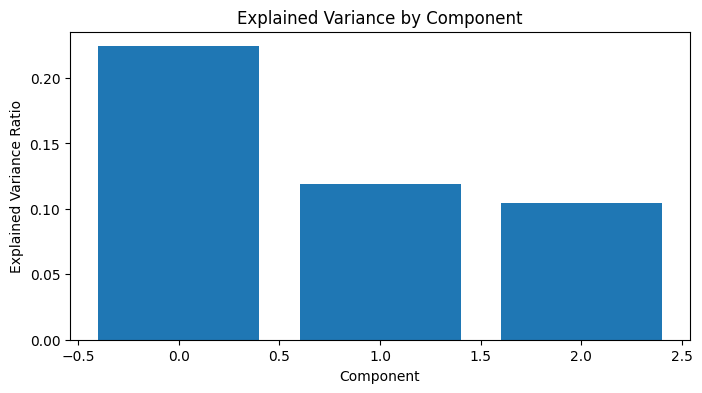

In [35]:
plot_explained_variance(pca)

In [40]:
feature_names = (
    dataloader.numerical_features +
    dataloader.categorical_features +
    dataloader.boolean_features
)
plot_feature_loadings(pca, feature_names, components=[0,1])

### Sparse PCA

In [7]:
X_sparse_pca, pipeline = dataloader.apply_sparse_pca(X, n_components=20)
sparse_pca = pipeline['sparse_pca']
#plot_reduced_data(X_sparse_pca, y, 'Sparse PCA')

In [37]:
plot_explained_variance(sparse_pca)

AttributeError: 'SparsePCA' object has no attribute 'explained_variance_ratio_'

<Figure size 800x400 with 0 Axes>

In [12]:
feature_names = (
    dataloader.numerical_features +
    dataloader.categorical_features +
    dataloader.boolean_features
)
plot_feature_loadings(sparse_pca, feature_names, components=[0,1,2])

C:\Users\trist\AppData\Local\Temp\ipykernel_2760\3290500648.py:52: RuntimeWarning:

invalid value encountered in divide



### t-SNE

In [ ]:
tsne_dict = dataloader.apply_tsne(X, n_components=3, by="track_genre")
plot_reduced_data(tsne_dict, y, 't-SNE')

['swedish' 'acoustic' 'children' 'j-pop' 'jazz' 'drum-and-bass' 'reggae'
 'reggaeton' 'songwriter' 'hardcore' 'industrial' 'anime' 'malay'
 'death-metal' 'brazil' 'black-metal' 'alternative' 'german' 'electronic'
 'rock' 'synth-pop' 'spanish' 'rock-n-roll' 'dancehall' 'blues' 'j-dance'
 'disco' 'salsa' 'indie' 'happy' 'groove' 'j-idol' 'folk' 'club'
 'power-pop' 'turkish' 'techno' 'metal' 'minimal-techno'
 'singer-songwriter' 'guitar' 'edm' 'emo' 'indie-pop' 'disney' 'trip-hop'
 'comedy' 'cantopop' 'hardstyle' 'dub' 'dance' 'alt-rock' 'romance'
 'latin' 'trance' 'opera' 'electro' 'dubstep' 'mpb' 'pagode' 'breakbeat'
 'progressive-house' 'hip-hop' 'country' 'indian' 'grunge' 'latino'
 'deep-house' 'detroit-techno' 'show-tunes' 'forro' 'french' 'sertanejo'
 'new-age' 'bluegrass' 'j-rock' 'punk' 'ambient' 'party' 'psych-rock'
 'world-music' 'r-n-b' 'british' 'afrobeat' 'kids' 'garage' 'sleep'
 'iranian' 'chill' 'mandopop' 'punk-rock' 'piano' 'metalcore' 'idm'
 'k-pop' 'heavy-metal' 'funk'

In [6]:
category = "track_genre"
categories = X[category]
X_without_category = X.drop(columns=list(set([category, "track_genre"])))
red_dict = dataloader.apply_tsne(X_without_category, n_components=3, except_col=category)
plot_reduced_data(red_dict, categories, 't-SNE')

### UMAP

In [5]:
category = "track_genre"
categories = X[category]
X_without_category = X.drop(columns=list(set([category, "track_genre"])))
red_dict = dataloader.apply_umap(X_without_category, n_components=3, except_col=["track_genre"])
plot_reduced_data(red_dict, categories, 'UMAP')